# 1. Raw Data Preprocess

## 1.1 Load raw.fif data

In [1]:
import os
import scipy.io as sio
import mne
from mne.datasets import sample

In [2]:
"""
set data path (load sample data from MNE)
"""
data_path = sample.data_path()
raw_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file C:\Users\dimpa\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...


    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


## 1.2 data filtering

In [3]:
"""
set low frequency & high frequency
"""
l_freq, h_freq = 1, 30
raw.filter(l_freq, h_freq, method='fir', fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.4s


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,150.15 Hz
Highpass,1.00 Hz
Lowpass,30.00 Hz


## 1.3 data resampling

In [9]:
"""
set resample frequency
"""
sfreq_resample = 480
raw = raw.resample(sfreq_resample)

Sampling frequency of the instance is already 480.0, returning unmodified.


## 1.4 plot events

In [11]:
"""
get events
"""
events = mne.find_events(raw, stim_channel="STI 014")

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


In [13]:
"""
set events id (for mne sample data, we ignore event 5 & 32)
"smiley": 5
"buttonpress": 32
"""
# LA: auditory/left
# RA: auditory/right
# LV: visual/left
# RV: visual/right
event_dict = {
    "LA": 1,
    "RA": 2,
    "LV": 3,
    "RV": 4,
}

C:\Users\dimpa\AppData\Local\Temp\ipykernel_54804\2314868964.py:4: RuntimeWarning: event 5 missing from event_id will be ignored
  fig = mne.viz.plot_events(
C:\Users\dimpa\AppData\Local\Temp\ipykernel_54804\2314868964.py:4: RuntimeWarning: event 32 missing from event_id will be ignored
  fig = mne.viz.plot_events(


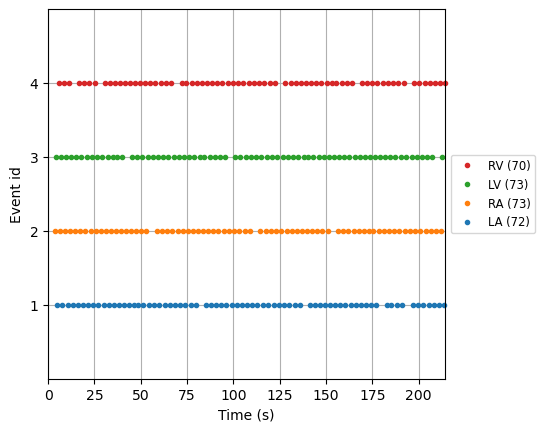

In [14]:
"""
plot events distribution
"""
fig = mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_dict
)

Using matplotlib as 2D backend.


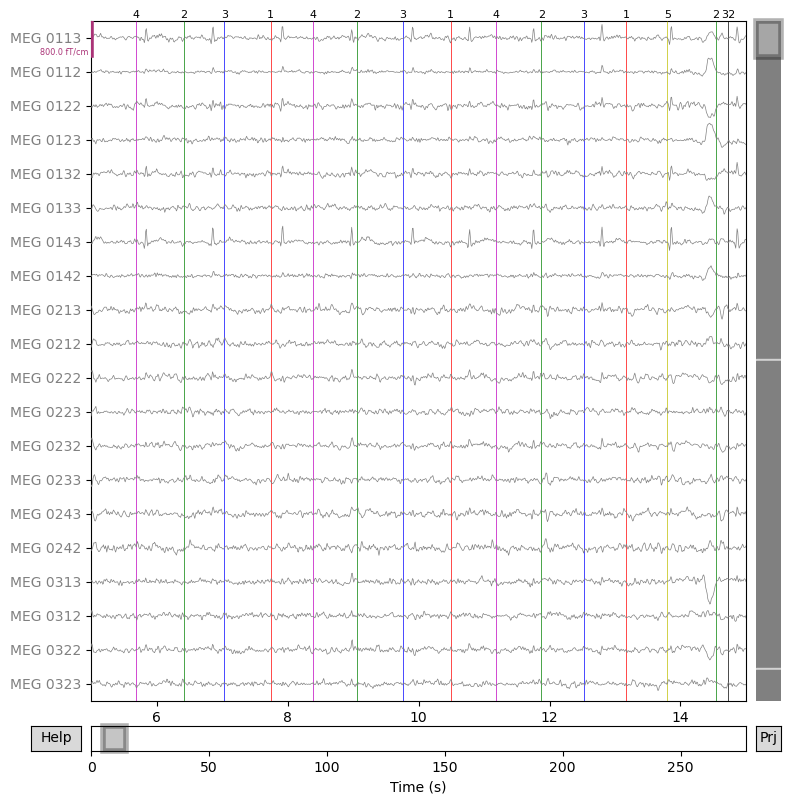

In [15]:
"""
plot events with raw data
"""
fig = raw.plot(
    events=events,
    start=5,
    duration=10,
    color="gray",
    event_color={1: "r", 2: "g", 3: "b", 4: "m", 5: "y", 32: "k"}, # set color according to events id
)

## 1.5 get averaged EEG data for each task

In [19]:
# choose event id from [1, 2, 3, 4] or ["LA", "RA", "LV", "RV"]
event_id = 'LA'

# set path to save data
path = './data/real_data/'
if not os.path.exists(path):
    os.makedirs(path)
fig_name = path + 'evoked_eeg_'+str(event_id)+'.png'
mat_name = path + 'evoked_eeg_'+str(event_id)+'.mat'

In [20]:
# fix
tmin = -0.1  # start of each epoch (100ms before the event)
tmax = 0.4  # end of each epoch (400ms after the event)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)
picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=True, exclude='bads')
epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject)
epoch_use = epochs[event_id]
evoked_use = epoch_use.average()

Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)


Created an SSP operator (subspace dimension = 4)
4 projection items activated
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']


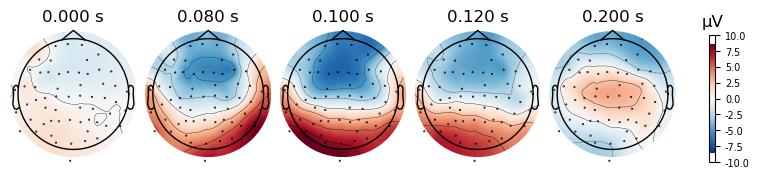

In [21]:
fig = evoked_use.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")
fig.savefig(fig_name, dpi=300, bbox_inches='tight')

In [22]:
data = evoked_use.data[:, :]
sio.savemat(mat_name, {'eeg': data})